<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_with_blurry_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" or folder_name == "glucoma" else 0

        for filename in tqdm(os.listdir(folder), desc=f"Loading {folder_name} images", total=total_files):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            if img is not None:
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

In [23]:
def apply_laplacian_threshold(images, labels, threshold):
    filtered_images = []
    filtered_labels = []

    for i in tqdm(range(len(images)), desc="Applying blur threshold"):
        blur = apply_laplacian_method(images[i])
        if blur > threshold:
            filtered_images.append(images[i])
            filtered_labels.append(labels[i])

    return np.array(filtered_images), np.array(filtered_labels)

In [7]:
def apply_laplacian_method(image):
    img = cv2.resize(image, (224, 224))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    return blur

In [25]:
def print_image_characteristics(images, labels):
    print("Number of images:", len(images))
    if len(images) > 0:
      print("Number of Healthy images:", np.count_nonzero(labels == 0))
      print("Number of Glaucomatous images:", np.count_nonzero(labels == 1))
      print("Image dimensions:", images[0].shape)
      print("Data type:", images[0].dtype)
      print("Range of pixel values:", np.min(images), "-", np.max(images))

In [22]:
# Load images from the source folder
source_dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'
images, labels= load_images_from_folder(source_dataset_path)
print_image_characteristics(images, labels)

Loading glaucoma images:  59%|█████▉    | 1608/2717 [01:33<01:04, 17.21it/s]


Number of images: 2717
Number of Healthy images: 1109
Number of Glaucomatous images: 1608
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


In [26]:
threshold=150
filtered_images, filtered_labels = apply_laplacian_threshold(images, labels, threshold)
print_image_characteristics(filtered_images, filtered_labels)

Applying blur threshold: 100%|██████████| 2717/2717 [00:01<00:00, 2632.52it/s]


Number of images: 1508
Number of Healthy images: 444
Number of Glaucomatous images: 1064
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


In [27]:
# Apply oversampling using SMOTE in the source domain
oversample_source = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled_source, y_train = oversample_source.fit_resample(filtered_images.reshape(-1, 224 * 224 * 3), filtered_labels)

# Reshape back to image format in the source domain
x_train = x_resampled_source.reshape(-1, 224, 224, 3)

print_image_characteristics(x_train, y_train)

Number of images: 2128
Number of Healthy images: 1064
Number of Glaucomatous images: 1064
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


In [29]:
# Split the data into training, validation and testing sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

# Print the size of each split dataset
print("Training set size:", x_train.shape[0])
print("Validation set size:", x_val.shape[0])
print("Testing set size:", x_test.shape[0])

Training set size: 1042
Validation set size: 223
Testing set size: 224


In [34]:
# Model architecture
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dropout(0.5))  # Add dropout layer for regularization
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model callbacks
callbacks_list = [
    ModelCheckpoint("/content/drive/MyDrive/vgg19_glaucoma.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode='max')
]

# Train the model
history = model.fit(x_train, y_train, batch_size=40,
                    epochs=20,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list,
                    class_weight={0: 1.0, 1: 1.0})  # Class weights can be adjusted based on requirements


# Evaluate the model on the target domain (testing set)
loss, accuracy = model.evaluate(x_val, y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)

loss1, accuracy1 = model.evaluate(x_test, y_test)
print("Loss:", loss1)
print("Accuracy:", accuracy1)

y_pred = (model.predict(x_val) > 0.5).astype(int)
print("Accuracy Score:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Glaucoma"], show_normed=True)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.9684
Epoch 1: val_accuracy improved from -inf to 0.97492, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 35s 620ms/step - loss: 0.5035 - accuracy: 0.9684 - val_loss: 0.4153 - val_accuracy: 0.9749
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9866
Epoch 2: val_accuracy did not improve from 0.97492
38/38 [==============================] - 9s 232ms/step - loss: 0.2549 - accuracy: 0.9866 - val_loss: 1.3683 - val_accuracy: 0.9687
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.9906
Epoch 3: val_accuracy improved from 0.97492 to 0.98433, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5
38/38 [==============================] - 11s 289ms/step - loss: 0.2875 - accuracy: 0.9906 - val_loss: 0.2227 - val_accuracy: 0.9843
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9973
Epoch 4: val_accuracy improved from 0.98433 to 0.98746, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5
38/38 [==============================] - 9s 24

10/10 [==============================] - 1s 140ms/step
Accuracy Score: 0.978125
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       175
           1       0.97      0.98      0.98       145

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

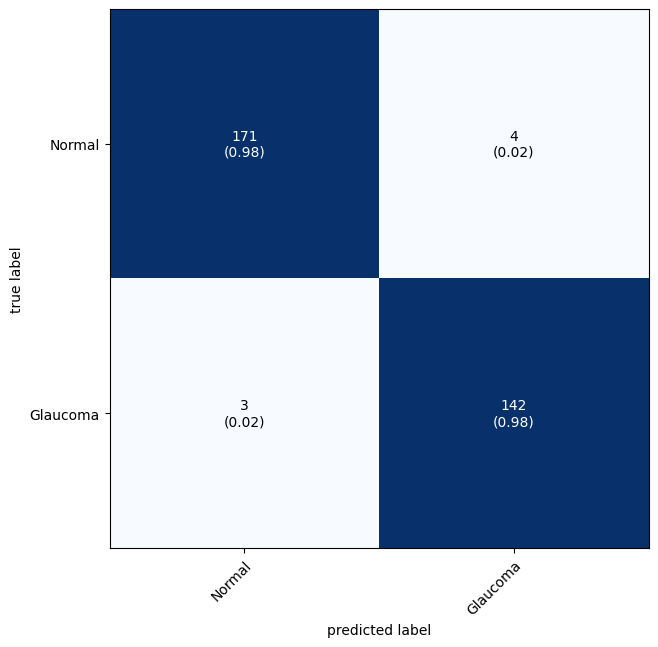

In [ ]:
y_pred = (model.predict(x_test) > 0.5).astype(int)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Glaucoma"], show_normed=True)

In [ ]:
model.save('/content/drive/MyDrive/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 139ms/step


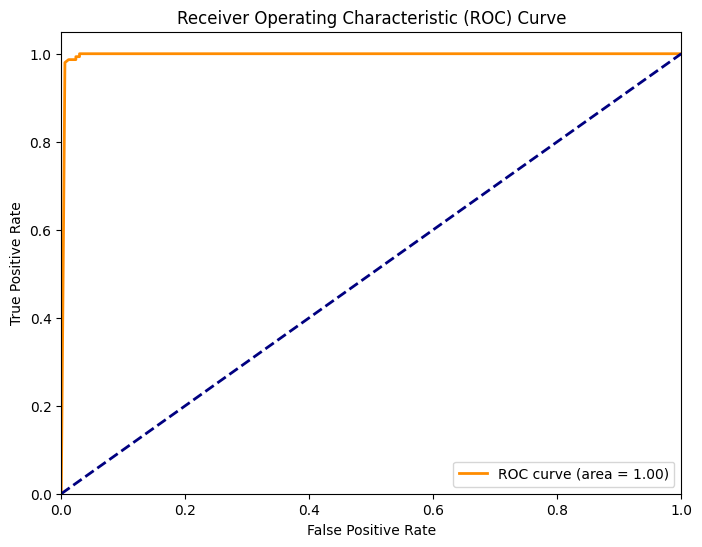

In [ ]:
from sklearn.metrics import roc_curve, auc

y_probs = model.predict(x_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

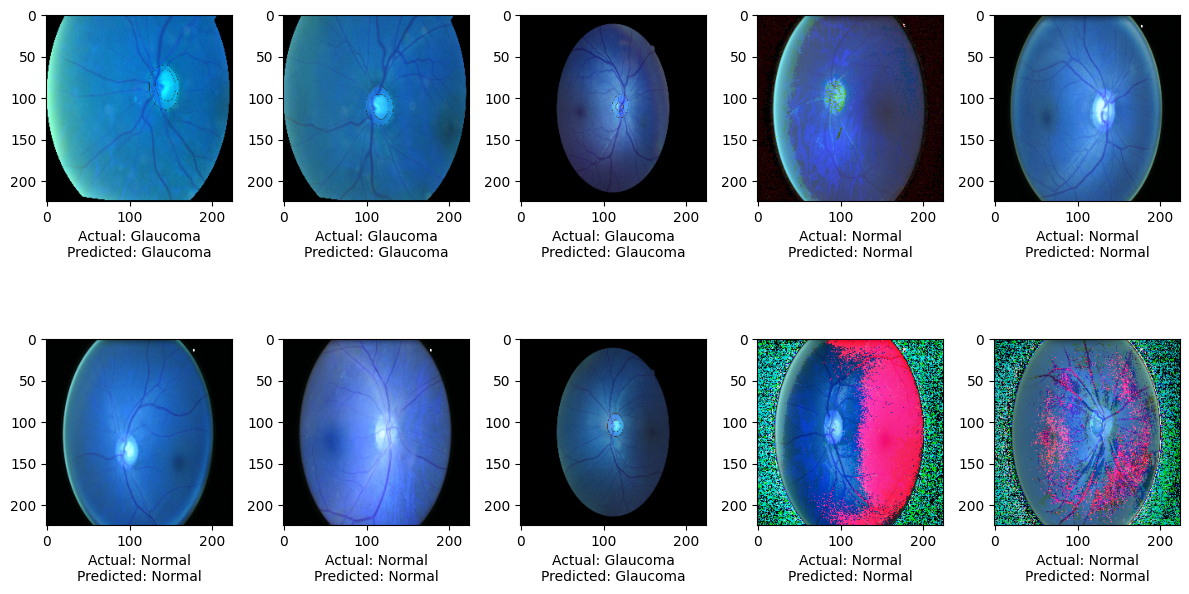

In [ ]:
#samples images with the predicted and actual label
import random

plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_val)))
    image = x_val[sample]
    category = y_val[sample]
    pred_category = y_pred[sample]

    label = "Normal" if category == 0 else "Glaucoma"
    pred_label = "Normal" if pred_category == 0 else "Glaucoma"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(f"Actual: {label}\nPredicted: {pred_label}")
plt.tight_layout()
plt.show()